<a href="https://colab.research.google.com/github/Shah12345678901/Classification-EMDS-/blob/main/vgg16_RF_XGB_SVM_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing The Libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import GridSearchCV

**Data loading**

In [ ]:
PATH='/content/drive/MyDrive/Colab Notebooks/EMDS5-Original'


train_dir = os.path.join(PATH, 'Train')
validation_dir = os.path.join(PATH, 'Val')



BATCH_SIZE = 1
SIZE=224
IMG_SIZE = (SIZE,SIZE)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 672 files belonging to 21 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 168 files belonging to 21 classes.


**Data Prepration for Training and Testing**

In [ ]:
train_batch_img=[]
train_batch_labels=[]
for img,labels in train_dataset:
  train_batch_img.append(img)
  train_batch_labels.append(labels)


In [ ]:
train_images=[]
train_labels=[]
for i in range(672):
  train_images.append(train_batch_img[i][0])
for j in range(672):
  train_labels.append(train_batch_labels[j][0])  

In [ ]:
#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)


In [ ]:
test_batch_img=[]
test_batch_labels=[]
for img,labels in validation_dataset:
  test_batch_img.append(img)
  test_batch_labels.append(labels)


In [ ]:
test_images=[]
test_labels=[]
for i in range(168):
  test_images.append(test_batch_img[i][0])
for j in range(168):
  test_labels.append(test_batch_labels[j][0]) 

In [ ]:
#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [ ]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
#One hot encode y values for neural network. 
#from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

**LOading the pretrained model and doing Feature extraction**

In [ ]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=True, input_shape=(SIZE, SIZE, 3))

553476096/553467096 [==============================] - 3s 0us/step


In [ ]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False

In [ ]:
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Applying ML classifer on feature extracted by the Pretrained model**

**RANDOM FOREST**

In [ ]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

In [ ]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [ ]:
X_for_RF = features #This is our X input to RF

In [ ]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 30, random_state = 42)

In [ ]:
# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

RandomForestClassifier(n_estimators=30, random_state=42)

In [ ]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.4880952380952381


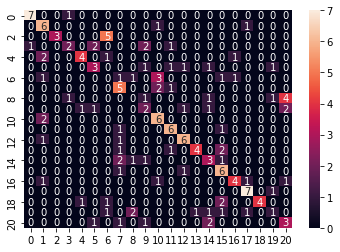

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

The prediction for this image is:  [4]
The actual label for this image is:  4


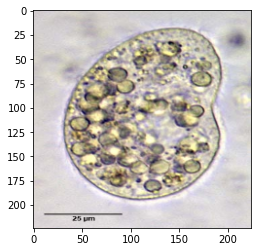

In [ ]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])

**RF after getting best param after GridSearch**

In [ ]:
best_param= {'n_estimators': 50}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_grid_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [ ]:
# Train the model on training data
RF_grid_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

RandomForestClassifier(n_estimators=50, random_state=42)

In [ ]:
#Now predict using the trained RF model. 
prediction_RF = RF_grid_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.5059523809523809


**XGBOOST**

In [ ]:
#Now, let us use features from convolutional network for XGBOOST
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_XGBOOST = features #This is our X input to XGBOOST

In [ ]:
#XGBOOST
import xgboost as xgb
XGBOOST_model = xgb.XGBClassifier()
XGBOOST_model.fit(X_for_XGBOOST, y_train) #For sklearn no one hot encoding

XGBClassifier(objective='multi:softprob')

In [ ]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
#Now predict using the trained XGBOOST model. 
prediction = XGBOOST_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.5773809523809523


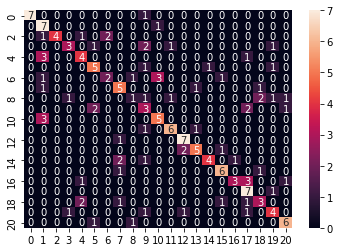

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

The prediction for this image is:  [10]
The actual label for this image is:  10


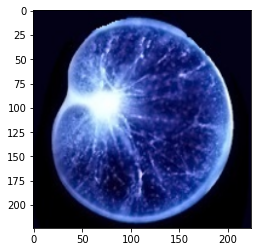

In [ ]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = XGBOOST_model.predict(input_img_features)[0] 
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

**HYPERPARAMETER TUNNING FOR XGBOOST USING OPTUNA**

In [ ]:
from sklearn.metrics import mean_squared_error
def objective(trail):
  train_x,test_x,train_y,test_y=train_test_split(X_for_XGBOOST,y_train,test_size=0.10,random_state=30)

  param={
        'tree_method':'gpu_hist',
        'lambda':trail.suggest_loguniform('lambad',1e-3,10.0),
        'alpha' :trail.suggest_loguniform('alpha',1e-3,10.0),
        'colsample_bytree':trail.suggest_categorical('colsample_bytree',[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]),
        'subsample':trail.suggest_categorical('subsample',[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]),
        'learning_rate':trail.suggest_categorical('learning_rate',[.00001,.02,.0003,.4,.5,.6,.7,.008,.9,.01,1,20,0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimator':[150,200,300,30000],
        'max_depth':trail.suggest_categorical('max_depth',[3,4,5,6,7,8,9,10,11,12,15,17]),
        'random_state':trail.suggest_categorical('random_state',[10,20,42,30,2000,3454,243123]),
        'min_child_weight':trail.suggest_int('min_child_weight',1,300),
        'verbosity':3,
        
        
        
    }
    
    
  xgb_optuna_model=xgb.XGBClassifier(**param)
  xgb_optuna_model.fit(train_x,train_y,eval_set=[(test_x,test_y)],verbose=True)
  pred_xgb=xgb_optuna_model.predict(test_x)
  rmse=mean_squared_error(test_y,pred_xgb)
  return rmse

In [ ]:
find_param=optuna.create_study(direction='minimize')
find_param.optimize(objective,n_trials=10)
find_param.best_trial.params


[I 2022-06-13 07:23:29,753] A new study created in memory with name: no-name-dd9c00a1-e70b-4b69-a34f-4399b8a74377


[0]	validation_0-merror:0.941176
[1]	validation_0-merror:0.941176
[2]	validation_0-merror:0.941176
[3]	validation_0-merror:0.941176
[4]	validation_0-merror:0.941176
[5]	validation_0-merror:0.941176
[6]	validation_0-merror:0.941176
[7]	validation_0-merror:0.941176
[8]	validation_0-merror:0.941176
[9]	validation_0-merror:0.941176
[10]	validation_0-merror:0.941176
[11]	validation_0-merror:0.941176
[12]	validation_0-merror:0.941176
[13]	validation_0-merror:0.941176
[14]	validation_0-merror:0.941176
[15]	validation_0-merror:0.941176
[16]	validation_0-merror:0.941176
[17]	validation_0-merror:0.941176
[18]	validation_0-merror:0.941176
[19]	validation_0-merror:0.941176
[20]	validation_0-merror:0.941176
[21]	validation_0-merror:0.941176
[22]	validation_0-merror:0.941176
[23]	validation_0-merror:0.941176
[24]	validation_0-merror:0.941176
[25]	validation_0-merror:0.941176
[26]	validation_0-merror:0.941176
[27]	validation_0-merror:0.941176
[28]	validation_0-merror:0.941176
[29]	validation_0-merror

[I 2022-06-13 07:23:41,642] Trial 0 finished with value: 136.63235294117646 and parameters: {'lambad': 0.002605895699491192, 'alpha': 0.008236278056565256, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.4, 'max_depth': 15, 'random_state': 2000, 'min_child_weight': 233}. Best is trial 0 with value: 136.63235294117646.


[07:23:41] ======== Monitor: Learner ========
[07:23:41] EvalOneIter: 0.00793087s, 100 calls @ 79us
[07:23:41] GetGradient: 0.0088207s, 100 calls @ 88us
[07:23:41] PredictRaw: 0.00352843s, 100 calls @ 35us
[07:23:41] UpdateOneIter: 11.6805s, 100 calls @ 116805us
[07:23:41] ======== Monitor: GBTree ========
[07:23:41] BoostNewTrees: 11.6576s, 100 calls @ 116576us
[07:23:41] CommitModel: 0.00988934s, 100 calls @ 98us
[07:23:41] ======== Monitor:  ========
[07:23:41] DevicePredictInternal: 0.0100083s, 201 calls @ 49us
[07:23:41] PredictFromCache: 0.00412932s, 199 calls @ 20us
[07:23:41] ======== Monitor: updater_gpu_hist ========
[07:23:41] BinningCompression: 0.00322984s, 1 calls @ 3229us
[07:23:41] InitData: 0.367792s, 2100 calls @ 175us
[07:23:41] InitDataOnce: 0.367229s, 1 calls @ 367229us
[07:23:41] Quantiles: 0.354964s, 1 calls @ 354963us
[07:23:41] Update: 11.5892s, 2100 calls @ 5518us
[07:23:41] ======== NCCL Statistics========
[07:23:41] AllReduce calls: 4200
[07:23:41] AllReduce

[I 2022-06-13 07:23:54,008] Trial 1 finished with value: 136.63235294117646 and parameters: {'lambad': 0.005920008839474735, 'alpha': 0.0423907116532195, 'colsample_bytree': 1, 'subsample': 0.6, 'learning_rate': 0.9, 'max_depth': 17, 'random_state': 243123, 'min_child_weight': 252}. Best is trial 0 with value: 136.63235294117646.


[07:23:53] ======== Monitor: Learner ========
[07:23:53] EvalOneIter: 0.00833476s, 100 calls @ 83us
[07:23:53] GetGradient: 0.00709918s, 100 calls @ 70us
[07:23:53] PredictRaw: 0.00326385s, 100 calls @ 32us
[07:23:53] UpdateOneIter: 12.151s, 100 calls @ 121510us
[07:23:53] ======== Monitor: GBTree ========
[07:23:53] BoostNewTrees: 12.1294s, 100 calls @ 121294us
[07:23:53] CommitModel: 0.0104523s, 100 calls @ 104us
[07:23:53] ======== Monitor:  ========
[07:23:53] DevicePredictInternal: 0.0104871s, 201 calls @ 52us
[07:23:53] PredictFromCache: 0.00416911s, 199 calls @ 20us
[07:23:53] ======== Monitor: updater_gpu_hist ========
[07:23:53] BinningCompression: 0.00470737s, 1 calls @ 4707us
[07:23:53] InitData: 0.29053s, 2100 calls @ 138us
[07:23:53] InitDataOnce: 0.289997s, 1 calls @ 289997us
[07:23:53] Quantiles: 0.275666s, 1 calls @ 275666us
[07:23:53] Update: 12.0557s, 2100 calls @ 5740us
[07:23:53] ======== NCCL Statistics========
[07:23:53] AllReduce calls: 4200
[07:23:53] AllReduce 

[I 2022-06-13 07:24:05,449] Trial 2 finished with value: 39.86764705882353 and parameters: {'lambad': 0.09125018144442715, 'alpha': 0.02096917884055731, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.016, 'max_depth': 10, 'random_state': 30, 'min_child_weight': 36}. Best is trial 2 with value: 39.86764705882353.


[07:24:05] ======== Monitor: Learner ========
[07:24:05] EvalOneIter: 0.00830637s, 100 calls @ 83us
[07:24:05] GetGradient: 0.00738082s, 100 calls @ 73us
[07:24:05] PredictRaw: 0.00475438s, 100 calls @ 47us
[07:24:05] UpdateOneIter: 11.2185s, 100 calls @ 112185us
[07:24:05] ======== Monitor: GBTree ========
[07:24:05] BoostNewTrees: 11.1955s, 100 calls @ 111954us
[07:24:05] CommitModel: 0.0102665s, 100 calls @ 102us
[07:24:05] ======== Monitor:  ========
[07:24:05] DevicePredictInternal: 0.0103802s, 201 calls @ 51us
[07:24:05] PredictFromCache: 0.00419427s, 199 calls @ 21us
[07:24:05] ======== Monitor: updater_gpu_hist ========
[07:24:05] BinningCompression: 0.00248868s, 1 calls @ 2488us
[07:24:05] InitData: 0.268433s, 2100 calls @ 127us
[07:24:05] InitDataOnce: 0.267885s, 1 calls @ 267885us
[07:24:05] Quantiles: 0.257503s, 1 calls @ 257502us
[07:24:05] Update: 11.1293s, 2100 calls @ 5299us
[07:24:05] ======== NCCL Statistics========
[07:24:05] AllReduce calls: 4200
[07:24:05] AllReduc

[I 2022-06-13 07:24:16,910] Trial 3 finished with value: 39.86764705882353 and parameters: {'lambad': 0.7697630180413847, 'alpha': 0.0019817957147868115, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 3, 'random_state': 20, 'min_child_weight': 26}. Best is trial 2 with value: 39.86764705882353.


[07:24:16] ======== Monitor: Learner ========
[07:24:16] EvalOneIter: 0.00856363s, 100 calls @ 85us
[07:24:16] GetGradient: 0.00744963s, 100 calls @ 74us
[07:24:16] PredictRaw: 0.00338702s, 100 calls @ 33us
[07:24:16] UpdateOneIter: 11.2252s, 100 calls @ 112251us
[07:24:16] ======== Monitor: GBTree ========
[07:24:16] BoostNewTrees: 11.2034s, 100 calls @ 112034us
[07:24:16] CommitModel: 0.0101777s, 100 calls @ 101us
[07:24:16] ======== Monitor:  ========
[07:24:16] DevicePredictInternal: 0.0103979s, 201 calls @ 51us
[07:24:16] PredictFromCache: 0.00432772s, 199 calls @ 21us
[07:24:16] ======== Monitor: updater_gpu_hist ========
[07:24:16] BinningCompression: 0.00246393s, 1 calls @ 2463us
[07:24:16] InitData: 0.269933s, 2100 calls @ 128us
[07:24:16] InitDataOnce: 0.269385s, 1 calls @ 269385us
[07:24:16] Quantiles: 0.258989s, 1 calls @ 258989us
[07:24:16] Update: 11.1357s, 2100 calls @ 5302us
[07:24:16] ======== NCCL Statistics========
[07:24:16] AllReduce calls: 4200
[07:24:16] AllReduc

[I 2022-06-13 07:24:28,086] Trial 4 finished with value: 136.63235294117646 and parameters: {'lambad': 0.9173518198144954, 'alpha': 9.235439139604082, 'colsample_bytree': 0.2, 'subsample': 0.2, 'learning_rate': 1e-05, 'max_depth': 10, 'random_state': 20, 'min_child_weight': 100}. Best is trial 2 with value: 39.86764705882353.


[07:24:28] ======== Monitor: Learner ========
[07:24:28] EvalOneIter: 0.00827678s, 100 calls @ 82us
[07:24:28] GetGradient: 0.00746947s, 100 calls @ 74us
[07:24:28] PredictRaw: 0.00346928s, 100 calls @ 34us
[07:24:28] UpdateOneIter: 10.9537s, 100 calls @ 109537us
[07:24:28] ======== Monitor: GBTree ========
[07:24:28] BoostNewTrees: 10.9321s, 100 calls @ 109321us
[07:24:28] CommitModel: 0.00998748s, 100 calls @ 99us
[07:24:28] ======== Monitor:  ========
[07:24:28] DevicePredictInternal: 0.0103527s, 201 calls @ 51us
[07:24:28] PredictFromCache: 0.00424111s, 199 calls @ 21us
[07:24:28] ======== Monitor: updater_gpu_hist ========
[07:24:28] BinningCompression: 0.00246498s, 1 calls @ 2464us
[07:24:28] InitData: 0.267214s, 2100 calls @ 127us
[07:24:28] InitDataOnce: 0.266659s, 1 calls @ 266658us
[07:24:28] Quantiles: 0.25631s, 1 calls @ 256310us
[07:24:28] Update: 10.8653s, 2100 calls @ 5173us
[07:24:28] ======== NCCL Statistics========
[07:24:28] AllReduce calls: 4200
[07:24:28] AllReduce

[I 2022-06-13 07:24:39,386] Trial 5 finished with value: 136.63235294117646 and parameters: {'lambad': 0.002819521977128983, 'alpha': 0.03784005598317077, 'colsample_bytree': 0.4, 'subsample': 0.1, 'learning_rate': 1, 'max_depth': 10, 'random_state': 20, 'min_child_weight': 160}. Best is trial 2 with value: 39.86764705882353.


[07:24:39] ======== Monitor: Learner ========
[07:24:39] EvalOneIter: 0.00792373s, 100 calls @ 79us
[07:24:39] GetGradient: 0.00885016s, 100 calls @ 88us
[07:24:39] PredictRaw: 0.00316106s, 100 calls @ 31us
[07:24:39] UpdateOneIter: 11.0868s, 100 calls @ 110867us
[07:24:39] ======== Monitor: GBTree ========
[07:24:39] BoostNewTrees: 11.0642s, 100 calls @ 110642us
[07:24:39] CommitModel: 0.00994692s, 100 calls @ 99us
[07:24:39] ======== Monitor:  ========
[07:24:39] DevicePredictInternal: 0.0103702s, 201 calls @ 51us
[07:24:39] PredictFromCache: 0.00399527s, 199 calls @ 20us
[07:24:39] ======== Monitor: updater_gpu_hist ========
[07:24:39] BinningCompression: 0.00252641s, 1 calls @ 2526us
[07:24:39] InitData: 0.256545s, 2100 calls @ 122us
[07:24:39] InitDataOnce: 0.255995s, 1 calls @ 255994us
[07:24:39] Quantiles: 0.244399s, 1 calls @ 244398us
[07:24:39] Update: 10.9992s, 2100 calls @ 5237us
[07:24:39] ======== NCCL Statistics========
[07:24:39] AllReduce calls: 4200
[07:24:39] AllReduc

[I 2022-06-13 07:24:50,964] Trial 6 finished with value: 136.63235294117646 and parameters: {'lambad': 0.37660460384692107, 'alpha': 0.16543062407637754, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 8, 'random_state': 3454, 'min_child_weight': 174}. Best is trial 2 with value: 39.86764705882353.


[07:24:50] ======== Monitor: Learner ========
[07:24:50] EvalOneIter: 0.00788225s, 100 calls @ 78us
[07:24:50] GetGradient: 0.00741326s, 100 calls @ 74us
[07:24:50] PredictRaw: 0.00449658s, 100 calls @ 44us
[07:24:50] UpdateOneIter: 11.3745s, 100 calls @ 113744us
[07:24:50] ======== Monitor: GBTree ========
[07:24:50] BoostNewTrees: 11.3524s, 100 calls @ 113523us
[07:24:50] CommitModel: 0.00957925s, 100 calls @ 95us
[07:24:50] ======== Monitor:  ========
[07:24:50] DevicePredictInternal: 0.00996635s, 201 calls @ 49us
[07:24:50] PredictFromCache: 0.00536929s, 199 calls @ 26us
[07:24:50] ======== Monitor: updater_gpu_hist ========
[07:24:50] BinningCompression: 0.00245272s, 1 calls @ 2452us
[07:24:50] InitData: 0.264099s, 2100 calls @ 125us
[07:24:50] InitDataOnce: 0.263523s, 1 calls @ 263522us
[07:24:50] Quantiles: 0.253325s, 1 calls @ 253325us
[07:24:50] Update: 11.2867s, 2100 calls @ 5374us
[07:24:50] ======== NCCL Statistics========
[07:24:50] AllReduce calls: 4200
[07:24:50] AllRedu

[I 2022-06-13 07:25:02,036] Trial 7 finished with value: 136.63235294117646 and parameters: {'lambad': 0.006983171754442029, 'alpha': 0.479234024255293, 'colsample_bytree': 0.1, 'subsample': 0.4, 'learning_rate': 0.012, 'max_depth': 8, 'random_state': 243123, 'min_child_weight': 210}. Best is trial 2 with value: 39.86764705882353.


[07:25:02] ======== Monitor: Learner ========
[07:25:02] EvalOneIter: 0.0078138s, 100 calls @ 78us
[07:25:02] GetGradient: 0.00736411s, 100 calls @ 73us
[07:25:02] PredictRaw: 0.00318996s, 100 calls @ 31us
[07:25:02] UpdateOneIter: 10.871s, 100 calls @ 108709us
[07:25:02] ======== Monitor: GBTree ========
[07:25:02] BoostNewTrees: 10.8499s, 100 calls @ 108498us
[07:25:02] CommitModel: 0.00997805s, 100 calls @ 99us
[07:25:02] ======== Monitor:  ========
[07:25:02] DevicePredictInternal: 0.010421s, 201 calls @ 51us
[07:25:02] PredictFromCache: 0.00399403s, 199 calls @ 20us
[07:25:02] ======== Monitor: updater_gpu_hist ========
[07:25:02] BinningCompression: 0.00278692s, 1 calls @ 2786us
[07:25:02] InitData: 0.261367s, 2100 calls @ 124us
[07:25:02] InitDataOnce: 0.260834s, 1 calls @ 260834us
[07:25:02] Quantiles: 0.249854s, 1 calls @ 249854us
[07:25:02] Update: 10.7856s, 2100 calls @ 5135us
[07:25:02] ======== NCCL Statistics========
[07:25:02] AllReduce calls: 4200
[07:25:02] AllReduce t

[I 2022-06-13 07:25:13,627] Trial 8 finished with value: 118.73529411764706 and parameters: {'lambad': 0.2816277556222666, 'alpha': 1.936855366314513, 'colsample_bytree': 1, 'subsample': 0.4, 'learning_rate': 20, 'max_depth': 8, 'random_state': 10, 'min_child_weight': 6}. Best is trial 2 with value: 39.86764705882353.


[07:25:13] ======== Monitor: Learner ========
[07:25:13] EvalOneIter: 0.00897335s, 100 calls @ 89us
[07:25:13] GetGradient: 0.00840296s, 100 calls @ 84us
[07:25:13] PredictRaw: 0.00310446s, 100 calls @ 31us
[07:25:13] UpdateOneIter: 11.3852s, 100 calls @ 113851us
[07:25:13] ======== Monitor: GBTree ========
[07:25:13] BoostNewTrees: 11.3627s, 100 calls @ 113626us
[07:25:13] CommitModel: 0.0104107s, 100 calls @ 104us
[07:25:13] ======== Monitor:  ========
[07:25:13] DevicePredictInternal: 0.0107756s, 201 calls @ 53us
[07:25:13] PredictFromCache: 0.00398752s, 199 calls @ 20us
[07:25:13] ======== Monitor: updater_gpu_hist ========
[07:25:13] BinningCompression: 0.00239256s, 1 calls @ 2392us
[07:25:13] InitData: 0.258962s, 2100 calls @ 123us
[07:25:13] InitDataOnce: 0.258437s, 1 calls @ 258437us
[07:25:13] Quantiles: 0.247935s, 1 calls @ 247934us
[07:25:13] Update: 11.2974s, 2100 calls @ 5379us
[07:25:13] ======== NCCL Statistics========
[07:25:13] AllReduce calls: 4264
[07:25:13] AllReduc

[I 2022-06-13 07:25:25,224] Trial 9 finished with value: 136.63235294117646 and parameters: {'lambad': 0.05958559631669116, 'alpha': 0.2558404535696696, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 3454, 'min_child_weight': 236}. Best is trial 2 with value: 39.86764705882353.


[07:25:25] ======== Monitor: Learner ========
[07:25:25] EvalOneIter: 0.00824655s, 100 calls @ 82us
[07:25:25] GetGradient: 0.00752978s, 100 calls @ 75us
[07:25:25] PredictRaw: 0.00327736s, 100 calls @ 32us
[07:25:25] UpdateOneIter: 11.393s, 100 calls @ 113929us
[07:25:25] ======== Monitor: GBTree ========
[07:25:25] BoostNewTrees: 11.371s, 100 calls @ 113710us
[07:25:25] CommitModel: 0.0105417s, 100 calls @ 105us
[07:25:25] ======== Monitor:  ========
[07:25:25] DevicePredictInternal: 0.0106318s, 201 calls @ 52us
[07:25:25] PredictFromCache: 0.00437942s, 199 calls @ 22us
[07:25:25] ======== Monitor: updater_gpu_hist ========
[07:25:25] BinningCompression: 0.0028589s, 1 calls @ 2858us
[07:25:25] InitData: 0.261058s, 2100 calls @ 124us
[07:25:25] InitDataOnce: 0.260487s, 1 calls @ 260486us
[07:25:25] Quantiles: 0.249577s, 1 calls @ 249576us
[07:25:25] Update: 11.3034s, 2100 calls @ 5382us
[07:25:25] ======== NCCL Statistics========
[07:25:25] AllReduce calls: 4200
[07:25:25] AllReduce t

{'alpha': 0.02096917884055731,
 'colsample_bytree': 0.5,
 'lambad': 0.09125018144442715,
 'learning_rate': 0.016,
 'max_depth': 10,
 'min_child_weight': 36,
 'random_state': 30,
 'subsample': 0.4}

In [ ]:
find_param.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambad,params_learning_rate,params_max_depth,params_min_child_weight,params_random_state,params_subsample,state
0,0,136.632353,2022-06-13 06:35:05.581440,2022-06-13 06:35:17.660837,0 days 00:00:12.079397,0.917262,0.8,0.845579,0.0003,4,121,243123,0.4,COMPLETE
1,1,13.485294,2022-06-13 06:35:17.662753,2022-06-13 06:35:30.900580,0 days 00:00:13.237827,0.000314,0.9,0.001595,0.6000,3,2,2000,0.4,COMPLETE
2,2,136.632353,2022-06-13 06:35:30.902446,2022-06-13 06:35:42.120721,0 days 00:00:11.218275,0.037788,0.4,7.753401,0.0200,3,86,20,0.2,COMPLETE
3,3,39.867647,2022-06-13 06:35:42.122662,2022-06-13 06:35:53.498079,0 days 00:00:11.375417,0.000108,0.5,0.001248,0.0003,9,18,243123,0.1,COMPLETE
4,4,136.632353,2022-06-13 06:35:53.499880,2022-06-13 06:36:04.572616,0 days 00:00:11.072736,0.000638,0.1,0.022064,1.0000,12,168,30,0.3,COMPLETE
5,5,136.632353,2022-06-13 06:36:04.574373,2022-06-13 06:36:16.380821,0 days 00:00:11.806448,1.581206,0.8,0.000640,20.0000,10,145,2000,0.4,COMPLETE
6,6,136.632353,2022-06-13 06:36:16.387016,2022-06-13 06:36:27.706346,0 days 00:00:11.319330,0.936740,0.4,2.078460,0.4000,6,65,10,0.2,COMPLETE
7,7,136.632353,2022-06-13 06:36:27.708077,2022-06-13 06:36:39.241612,0 days 00:00:11.533535,0.000328,0.7,0.039165,0.0100,3,68,30,0.8,COMPLETE
8,8,39.867647,2022-06-13 06:36:39.243652,2022-06-13 06:36:51.013309,0 days 00:00:11.769657,0.098724,0.5,5.593422,0.6000,7,25,20,0.3,COMPLETE
9,9,39.867647,2022-06-13 06:36:51.015253,2022-06-13 06:37:02.578447,0 days 00:00:11.563194,0.001294,1.0,0.072284,0.0080,8,32,2000,0.3,COMPLETE


In [ ]:
optuna.visualization.plot_optimization_history(find_param)

In [ ]:
optuna.visualization.plot_slice(find_param)

In [ ]:
best_param={'alpha': 0.02096917884055731,
 'colsample_bytree': 0.5,
 'lambad': 0.09125018144442715,
 'learning_rate': 0.016,
 'max_depth': 10,
 'min_child_weight': 36,
 'random_state': 30,
 'subsample': 0.4}

In [ ]:
#XGBOOST
import xgboost as xgb
XGBOOST_final_model = xgb.XGBClassifier(**best_param)
XGBOOST_final_model.fit(X_for_XGBOOST, y_train) #For sklearn no one hot encoding

XGBClassifier(alpha=0.02096917884055731, colsample_bytree=0.5,
              lambad=0.09125018144442715, learning_rate=0.016, max_depth=10,
              min_child_weight=36, objective='multi:softprob', random_state=30,
              subsample=0.4)

In [ ]:
#Now predict using the trained XGBOOST model. 
prediction = XGBOOST_final_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.047619047619047616


**SVM**

In [ ]:
from sklearn.svm import SVC

In [ ]:
#Now, let us use features from convolutional network for SVM
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to SVC

In [ ]:
svc= SVC()
svc_model=svc.fit(X_for_training,y_train)


In [ ]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
#Now predict using the trained XGBOOST model. 
prediction = svc_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.24404761904761904


**SVM after getting best param after GridSearch**

In [ ]:
best_param={'C': 2, 'kernel': 'linear','t':0,'s':0}
         

In [ ]:
svc= SVC(**best_param)
svc_grid_model=svc.fit(X_for_training,y_train)

In [ ]:
#Now predict using the trained XGBOOST model. 
prediction = svc_grid_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.11904761904761904


**GRid Search for RF and SVM**

In [ ]:
#Take a subset of train for grid search. Let us take 5% for now
from sklearn.model_selection import train_test_split
x_grid, x_not_use, y_grid, y_not_use = train_test_split(x_train, y_train, test_size=0.98, random_state=42)

In [ ]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_grid)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_RF = features #This is our X input to RF

In [ ]:
#RANDOM FOREST ONLY
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_grid) #For sklearn no one hot encoding

RandomForestClassifier(n_estimators=50, random_state=42)

In [ ]:
#Send test data through same feature extractor process
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

Accuracy =  0.08928571428571429


In [ ]:
train_x,test_x,train_y,test_y=train_test_split(X_for_RF,y_train,test_size=0.10,random_state=30)
###########################################################
# GRID SEARCH to find the best model and parameters
#########################################################
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1],  #Regularization parameter. Providing only two as SVM is slow
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [10,20,30,50]
        }
    }
}


scores = []

for model_name, mp in model_params.items():
    grid =  GridSearchCV(estimator=mp['model'], 
                         param_grid=mp['params'], 
                         cv=2, n_jobs=16, 
                         return_train_score=False)
    
    grid.fit(train_x, train_y)
    
    scores.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })

import pandas as pd    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

print(df)

           model  best_score                best_params
0            svm    0.096026  {'C': 1, 'kernel': 'rbf'}
1  random_forest    0.466887       {'n_estimators': 30}
